# Conv1D TN-seq classifier (aggregate + time course)

This notebook builds per-gene Conv1D features from the Pf3D7 TN-seq dataset, using both:

- **Aggregated counts** across all control samples at day ≥ 8  
- **Per-sample time course counts** (control samples, day ≥ 8, ordered by day)

It then trains a 1D CNN to predict gene dispensability (0 = essential, 1 = dispensable) using Kritika's background gene set, evaluates performance with stratified cross-validation, fits a final model, and generates:

- Genome-wide **P(dispensable | data)** predictions
- ROC curve, confusion matrices, and classification report on the background set
- Ranked probability curve with background and John Adams (JA) genes overlaid
- UMAP of the penultimate latent features, colored by class


In [66]:
# ================================================================
# Cell 1: Imports and basic settings
# ================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
)

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, Input

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 160)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.2


In [67]:
# ================================================================
# Cell 2: Paths and input loading
# ================================================================
# NOTE: Update these paths if your directory structure changes.
sample_meta_file = Path("../Output/PfTPN_sample_metadata.parquet")
cm_file          = Path("../Input/Genome/Pf3D7_gene_ttaa_rel_loc_len_counts_per_sample.parquet")
bg_genes_file    = Path("../Input/Genome/kritika_background_genes_kz.xlsx")
ja_ko_file       = Path("../Input/JA_falsecalls/Gene KO table.xlsx")

print("Loading count matrix (per TTAA, per sample) ...")
cm = pd.read_parquet(cm_file)

print("Loading sample metadata ...")
sample_meta = pd.read_parquet(sample_meta_file)

print("Loading Kritika background gene set (sheet 1) ...")
bg_genes = pd.read_excel(bg_genes_file, sheet_name=0)

print("Shapes:")
print("  cm          :", cm.shape)
print("  sample_meta :", sample_meta.shape)
print("  bg_genes    :", bg_genes.shape)

print("\nHead of cm:")
display(cm.head())

print("\nHead of sample_meta:")
display(sample_meta.head())

Loading count matrix (per TTAA, per sample) ...
Loading sample metadata ...
Loading Kritika background gene set (sheet 1) ...
Shapes:
  cm          : (161375, 145)
  sample_meta : (135, 13)
  bg_genes    : (342, 4)

Head of cm:


,GeneID,chrom,ttaa_start,ttaa_end,strand,cds_length,ttaa_cds_pos,ttaa_cds_frac,n_TTAA_cds,Site_ID,TC_pTN9_day0_Control,TC_pTN9_day15_Control,TC_pTN9_day15_Mev,TC_pTN9_day20_Control,TC_pTN9_day20_Mev,TC_pTN9_day8_Control,TC_pTN9_day8_Mev,Plasmid_D0_Control,TC_PTPN_day14_Mev,TC_PTPN_day14_Control,TC_PTPN_day17_Mev,TC_PTPN_day17_Control,TC_PTPN_day20_Mev,TC_PTPN_day20_Control,TC_PTPN_day8_Control,...,TC_Exp_exp6_day40_Acet_b0508_rep2,TC_Exp_exp6_day40_Mev_b0508,TC_Exp_exp6_day40_Mev_b0508_rep2,TC_Exp_exp6_day8_Control_b0508,TC_Exp_exp6_day8_Acet_b0508,TC_Exp_exp6_day8_Mev_b0508,TC_Exp_exp7_day14_Control_b0508,TC_Exp_exp7_day14_Acet_b0508,TC_Exp_exp7_day14_Mev_b0508,TC_Exp_exp7_day16_Control_b0508,TC_Exp_exp7_day16_Acet_b0508,TC_Exp_exp7_day16_Mev_b0508,TC_Exp_exp7_day18_Control_b0508,TC_Exp_exp7_day18_Acet_b0508,TC_Exp_exp7_day18_Mev_b0508,TC_Exp_exp7_day20_Acet_b0508,TC_Exp_exp7_day8_Control_b0508,TC_Exp_exp7_day8_Acet_b0508,TC_Exp_exp7_day8_Mev_b0508,TC_Exp_exp8_day17_Control_b0508,TC_Exp_exp8_day17_Mev_b0508,TC_Exp_exp8_day20_Control_b0508,TC_Exp_exp8_day20_Mev_b0508,TC_Exp_exp8_day26_Control_b0508,TC_Exp_exp8_day26_Mev_b0508
0,PF3D7_0100100,Pf3D7_01_v3,29865,29868,+,6492,356,0.054837,37,Pf3D7_01_v3:29865-29868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PF3D7_0100100,Pf3D7_01_v3,30318,30321,+,6492,809,0.124615,37,Pf3D7_01_v3:30318-30321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PF3D7_0100100,Pf3D7_01_v3,30512,30515,+,6492,1003,0.154498,37,Pf3D7_01_v3:30512-30515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PF3D7_0100100,Pf3D7_01_v3,30527,30530,+,6492,1018,0.156808,37,Pf3D7_01_v3:30527-30530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PF3D7_0100100,Pf3D7_01_v3,30585,30588,+,6492,1076,0.165742,37,Pf3D7_01_v3:30585-30588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Head of sample_meta:


,raw_name,group,exp_number,day,treatment,batch,person,is_timecourse,replicate,exp_label,batch_label,rep_label,new_name
0,pTN9_D0_TPN,pTN9,NaN,0.0,Control,NaN,None,True,1,None,None,None,TC_pTN9_day0_Control
1,pTN9_Day15_C_TPN,pTN9,NaN,15.0,Control,NaN,None,True,1,None,None,None,TC_pTN9_day15_Control
2,pTN9_Day15_M_TPN,pTN9,NaN,15.0,Mev,NaN,None,True,1,None,None,None,TC_pTN9_day15_Mev
3,pTN9_Day20_C_TPN,pTN9,NaN,20.0,Control,NaN,None,True,1,None,None,None,TC_pTN9_day20_Control
4,pTN9_Day20_M_TPN,pTN9,NaN,20.0,Mev,NaN,None,True,1,None,None,None,TC_pTN9_day20_Mev


In [68]:
# ================================================================
# Cell 3: Identify control samples with day >= 8 (time course)
# ================================================================
# We assume sample_meta has at least: new_name, treatment, day
required_cols = {"new_name", "treatment", "day"}
missing = required_cols.difference(sample_meta.columns)
if missing:
    raise ValueError(f"sample_meta missing required columns: {missing}")

# Control samples at day >= 8, sorted by day then name
ctrl_meta = (
    sample_meta
    .loc[
        (sample_meta["treatment"] == "Control") &
        sample_meta["day"].notna() &
        (sample_meta["day"] >= 14),
        ["new_name", "treatment", "day"],
    ]
    .drop_duplicates()
    .sort_values(["day", "new_name"])
)

ctrl_samples_sorted = ctrl_meta["new_name"].tolist()
print(f"Control samples (day >= 8), sorted by day: {len(ctrl_samples_sorted)}")
display(ctrl_meta)

# Count columns present in cm
count_cols_all = [c for c in cm.columns if c in sample_meta["new_name"].tolist()]
missing_ctrl = [c for c in ctrl_samples_sorted if c not in cm.columns]
if missing_ctrl:
    print("\nWARNING: These control samples are not columns in cm and will be dropped:")
    print(missing_ctrl)
    ctrl_samples_sorted = [c for c in ctrl_samples_sorted if c in cm.columns]

print(f"Using {len(ctrl_samples_sorted)} control sample columns in cm.")

Control samples (day >= 8), sorted by day: 45


,new_name,treatment,day
116,TC_Exp_exp7_day14_Control_b0508,Control,14.0
9,TC_PTPN_day14_Control,Control,14.0
18,TC_PTPN_day14_Control_b0504,Control,14.0
19,TC_PTPN_day14_Control_b0504_rep2,Control,14.0
37,TC_PTPN_day14_Control_b0505,Control,14.0
38,TC_PTPN_day14_Control_b0505_rep2,Control,14.0
67,TC_SM_exp6_day14_Control_b0507,Control,14.0
77,TC_SM_exp7_day14_Control_b0507,Control,14.0
87,TC_Exp_exp3_day15_Control_b0508,Control,15.0
1,TC_pTN9_day15_Control,Control,15.0


Using 45 control sample columns in cm.


In [69]:
# ================================================================
# Cell 4: Build per-gene Conv1D tensor (n_TTAA + aggregate + per-sample)
# ================================================================
BINS = 100

# We expect these annotation columns from the "rel_loc_len" file:
required_cols_cm = {"GeneID", "ttaa_cds_frac", "cds_length"}
missing_cols_cm = required_cols_cm.difference(cm.columns)
if missing_cols_cm:
    raise ValueError(f"cm is missing required columns: {missing_cols_cm}")

# Optionally restrict to exonic TTAA sites (as in previous pipeline)
if "Location" in cm.columns:
    cm_valid = cm.loc[
        (cm["Location"].astype(str).str.lower() == "exon")
        & cm["ttaa_cds_frac"].notna()
        & cm["cds_length"].notna()
    ].copy()
else:
    cm_valid = cm.loc[
        cm["ttaa_cds_frac"].notna()
        & cm["cds_length"].notna()
    ].copy()

print("Valid TTAA rows (after filters):", cm_valid.shape)

# Aggregate counts across all selected control samples
if ctrl_samples_sorted:
    cm_valid["ctrl_agg"] = cm_valid[ctrl_samples_sorted].sum(axis=1)
else:
    raise ValueError("No control samples found with day >= 8. Check sample_meta logic.")

# Gene list
genes_conv = (
    cm_valid[["GeneID", "cds_length"]]
    .drop_duplicates("GeneID")
    .sort_values("GeneID")
)["GeneID"].to_numpy()
N_genes = len(genes_conv)
print("Number of genes with at least one valid TTAA:", N_genes)

# Channels:
#   0 = n_TTAA sites per bin
#   1 = aggregate control counts (day >= 8) per bin
#   2..(2 + n_ctrl - 1) = per-sample control counts per bin
n_ctrl = len(ctrl_samples_sorted)
n_channels = 2 + n_ctrl

X_conv = np.zeros((N_genes, BINS, n_channels), dtype=np.float64)

# Quick mapping GeneID -> index into cm_valid for speed
cm_valid_by_gene = cm_valid.groupby("GeneID")

for i, g in enumerate(genes_conv):
    sub = cm_valid_by_gene.get_group(g)

    frac = sub["ttaa_cds_frac"].to_numpy(float)
    # Map [0,1] -> 0..BINS-1
    bin_idx = np.floor(frac * BINS).astype(int)
    bin_idx = np.clip(bin_idx, 0, BINS - 1)

    # 0) n_TTAA sites per bin
    n_ttaa_vec = np.bincount(bin_idx, minlength=BINS)
    if n_ttaa_vec.shape[0] < BINS:
        n_ttaa_vec = np.pad(n_ttaa_vec, (0, BINS - n_ttaa_vec.shape[0]))
    X_conv[i, :, 0] = n_ttaa_vec

    # 1) aggregate control counts across day >= 14
    agg_counts = sub["ctrl_agg"].to_numpy(float)
    agg_vec = np.bincount(bin_idx, weights=agg_counts, minlength=BINS)
    if agg_vec.shape[0] < BINS:
        agg_vec = np.pad(agg_vec, (0, BINS - agg_vec.shape[0]))
    X_conv[i, :, 1] = agg_vec

    # 2..: per-sample control counts
    for j, s in enumerate(ctrl_samples_sorted):
        counts_s = sub[s].to_numpy(float)
        vec_s = np.bincount(bin_idx, weights=counts_s, minlength=BINS)
        if vec_s.shape[0] < BINS:
            vec_s = np.pad(vec_s, (0, BINS - vec_s.shape[0]))
        X_conv[i, :, 2 + j] = vec_s

print("\nTensor summary:")
print("  X_conv shape:", X_conv.shape, "(N_genes, BINS, n_channels)")
print("  n_channels  :", n_channels)
print("  Example gene:", genes_conv[0])

# Optional: save features for reuse
out_npz = Path("../Output/conv1d_gene_features_bins100_ctrl_ge8_multichannel.npz")
np.savez_compressed(out_npz, genes=genes_conv, X=X_conv, ctrl_samples=np.array(ctrl_samples_sorted))
print("Saved per-gene features to:", out_npz)

Valid TTAA rows (after filters): (161375, 145)
Number of genes with at least one valid TTAA: 5312

Tensor summary:
  X_conv shape: (5312, 100, 47) (N_genes, BINS, n_channels)
  n_channels  : 47
  Example gene: PF3D7_0100100
Saved per-gene features to: ../Output/conv1d_gene_features_bins100_ctrl_ge8_multichannel.npz


In [70]:
# ================================================================
# Cell 5: Load Conv1D features into X_seq
# ================================================================
# If you've just executed Cell 4, you can reuse X_conv and genes_conv directly.
# Otherwise, reload from the NPZ.

npz_path = Path("../Output/conv1d_gene_features_bins100_ctrl_ge8_multichannel.npz")
data_npz = np.load(npz_path, allow_pickle=True)

genes_conv = data_npz["genes"]          # (N,)
X_conv     = data_npz["X"]              # (N, 100, C)

X_seq = X_conv.astype("float64")
seq_len = X_seq.shape[1]
n_channels = X_seq.shape[2]

print("genes_conv shape:", genes_conv.shape)
print("X_seq shape     :", X_seq.shape, "dtype:", X_seq.dtype)
print("seq_len         :", seq_len)
print("n_channels      :", n_channels)

genes_conv shape: (5312,)
X_seq shape     : (5312, 100, 47) dtype: float64
seq_len         : 100
n_channels      : 47


In [71]:
# ================================================================
# Cell 6: Background labels and alignment to Conv1D features
# ================================================================
print("Background classes in bg_genes['class']:")
print(bg_genes.groupby("class").size())

# Map textual class -> numeric label: 0 = essential, 1 = dispensable
cls = bg_genes["class"].astype(str).str.lower().str.strip()
mapping = {"essential": 0, "dispensable": 1}
bg_genes["label"] = cls.map(mapping)

if bg_genes["label"].isna().any():
    raise ValueError("Unmapped values in bg_genes['class']; please extend 'mapping'.")

# Sanity check if class_lab exists
if "class_lab" in bg_genes.columns:
    diff = (bg_genes["label"].astype(int) != bg_genes["class_lab"].astype(int)).sum()
    print(f"Rows where 'class' and 'class_lab' disagree: {diff}")

# Align to genes_conv order
gene_to_idx = {g: i for i, g in enumerate(genes_conv)}

mask_bg = bg_genes["GeneID"].isin(gene_to_idx)
bg_used = bg_genes.loc[mask_bg].reset_index(drop=True)

idx_bg = np.array([gene_to_idx[g] for g in bg_used["GeneID"]], dtype=int)

X_seq_bg = X_seq[idx_bg]              # (n_bg, 100, C)
y_bg     = bg_used["label"].to_numpy(dtype=int)

print("\nBackground genes with Conv1D features:", X_seq_bg.shape[0])
print("Class balance (0=essential, 1=dispensable):", np.bincount(y_bg))

# Class weights (global, used for all folds and final model)
classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_bg)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}

print("\nClass weights (for model.fit class_weight=...):")
print(class_weight_dict)

Background classes in bg_genes['class']:
class
dispensable    277
essential       65
dtype: int64
Rows where 'class' and 'class_lab' disagree: 0

Background genes with Conv1D features: 337
Class balance (0=essential, 1=dispensable): [ 65 272]

Class weights (for model.fit class_weight=...):
{0: 2.5923076923076924, 1: 0.6194852941176471}


In [72]:
# Global switch: turn engineered-feature augmentation on/off here
USE_FEAT = False

In [73]:
# ================================================================
# Cell 7: John Adams (JA) gene table – lab-validated vs wrong calls
# ================================================================
print("Loading JA KO table ...")
# Read all sheets, but we will address them by explicit names
ja_raw = pd.read_excel(ja_ko_file, sheet_name=None)
print("Sheets found in JA file:", list(ja_raw.keys()))

# ----------------------------------------------------------------
# 1) Lab-validated genes (sheet "Lab KOs")
#    Use the PlasmoDB column (PF3D7_...) as GeneID
# ----------------------------------------------------------------
if "Lab KOs" not in ja_raw:
    raise ValueError("Expected a sheet named 'Lab KOs' in JA KO file.")

ja_lab = ja_raw["Lab KOs"].copy()

# Standardize columns
# A: gene symbol, B: PlasmoDB, C: KO (Essential / Disp)
ja_lab = ja_lab.rename(
    columns={
        ja_lab.columns[0]: "geneName",   # DXR, oTPT, ...
        ja_lab.columns[1]: "GeneID",     # PF3D7_...
        ja_lab.columns[2]: "KO"          # Essential / Disp
    }
)

ja_lab["GeneID"] = ja_lab["GeneID"].astype(str).str.strip()
ja_lab["geneName"] = ja_lab["geneName"].astype(str).str.strip()

# Map KO -> label: 0 = Essential, 1 = Disp
ko_norm = ja_lab["KO"].astype(str).str.strip().str.lower()
ja_lab["label"] = ko_norm.map({"essential": 0, "disp": 1})

print("\nJA lab-validated genes (head):")
display(ja_lab.head())

# ----------------------------------------------------------------
# 2) JA “wrong” calls (sheet "Sheet1")
#    Use Gene_ID column (PF3D7_...) as GeneID
# ----------------------------------------------------------------
if "Sheet1" not in ja_raw:
    print("WARNING: Sheet 'Sheet1' (wrong calls) not found; creating empty frame.")
    ja_wrong = pd.DataFrame(columns=["GeneID", "geneName", "KO", "label"])
else:
    ja_wrong = ja_raw["Sheet1"].copy()

    # Expected structure:
    # A: Chr, B: Gene_ID, C: geneName, D: Product description, E: KO
    ja_wrong = ja_wrong.rename(
        columns={
            "Gene_ID": "GeneID",
            "geneName": "geneName",     # keep same if already present
            "KO": "KO"
        }
    )

    # If original columns don't match exactly, fall back to positional rename
    if "GeneID" not in ja_wrong.columns:
        ja_wrong.rename(columns={ja_wrong.columns[1]: "GeneID"}, inplace=True)
    if "geneName" not in ja_wrong.columns:
        ja_wrong.rename(columns={ja_wrong.columns[2]: "geneName"}, inplace=True)
    if "KO" not in ja_wrong.columns:
        ja_wrong.rename(columns={ja_wrong.columns[4]: "KO"}, inplace=True)

    ja_wrong["GeneID"] = ja_wrong["GeneID"].astype(str).str.strip()
    ja_wrong["geneName"] = ja_wrong["geneName"].astype(str).str.strip()

    ko_norm_wrong = ja_wrong["KO"].astype(str).str.strip().str.lower()
    ja_wrong["label"] = ko_norm_wrong.map({"essential": 0, "disp": 1})

print("\nJA 'wrong' calls (head):")
display(ja_wrong.head())
print("n_lab:", len(ja_lab), "  n_wrong:", len(ja_wrong))


Loading JA KO table ...
Sheets found in JA file: ['Lab KOs', 'PiggyBac Results', 'Sorted', 'Sheet1']

JA lab-validated genes (head):


,geneName,GeneID,KO,label
0,DXR,PF3D7_1467300,Essential,0
1,oTPT,PF3D7_0508300,Essential,0
2,iTPT,PF3D7_0530200,Essential,0
3,TPI,PF3D7_0318800,Disp,1
4,PyrKII,PF3D7_1037100,Essential,0



JA 'wrong' calls (head):


,Chr,GeneID,geneName,Product description,KO,Gene Identification,MIS,MFS,# of insertions in CDS,# of nor malized reads (raw)¶,Note*,# of TTAA in CDS,TTAA density in CDS,transcript length,geneStart,endStart,gene strand,Ortholog count,Paralog count,NonSyn/Syn SNP Ratio,GO Processes,GO Functions,GO Components,label
0,chr5,PF3D7_0530200,iTPT,phosphoenolpyruvate/phosphate translocator,Essential,Mutable in CDS,0.512,-3.138,1,20.76,NaN,29,18.41,1575,1229084,1230658,-,18,0,0.80,glucose import,glucose 6-phosphate:phosphate antiporter activ...,"apicoplast, integral component of plastid inne...",0
1,chr1,PF3D7_0104400,IspH,4-hydroxy-3-methylbut-2-enyl diphosphate reduc...,Essential,Mutable in CDS,0.993,-2.596,1,8.81,NaN,19,11.82,1608,202540,204147,+,18,0,2.00,"isopentenyl diphosphate biosynthetic process, ...",4-hydroxy-3-methylbut-2-en-1-yl diphosphate re...,apicoplast,0
2,chr14,PF3D7_1452300,Der1-1,DER1-like protein,Essential,Mutable in CDS,0.389,-1.070,1,128.49,NaN,21,19.72,1065,2145175,2146239,-,18,0,1.40,ER-associated ubiquitin-dependent protein cata...,ATPase activity,"apicoplast, integral component of membrane",0
3,chr10,PF3D7_1020800,aPDH E2,dihydrolipoamide acyltransferase component E2,Disp,Non - Mutable in CDS,0.136,-2.875,0,9.92,NaN,26,13.52,1923,840216,843407,+,18,0,1.50,"acetyl-CoA biosynthetic process from pyruvate,...",dihydrolipoyllysine-residue acetyltransferase ...,"apicoplast, membrane, pyruvate dehydrogenase c...",1
4,chr13,PF3D7_1344600,LipA,lipoyl synthase,Disp,Non - Mutable in CDS,0.135,-2.807,0,5.76,NaN,17,13.62,1248,1789455,1790702,+,18,0,0.82,NaN,NaN,apicoplast,1


n_lab: 48   n_wrong: 13


In [74]:
# ================================================================
# Engineered gene-level features aligned to genes_conv
# ================================================================

# 1) Identify control sample columns by day from sample_meta
ctrl_all_meta = (
    sample_meta
    .loc[
        (sample_meta["treatment"] == "Control") &
        sample_meta["day"].notna(),
        ["new_name", "day"]
    ]
    .drop_duplicates()
)

print("Unique Control time points:", sorted(ctrl_all_meta["day"].unique()))

# Day 8 controls
ctrl_day8_samples = ctrl_all_meta.loc[ctrl_all_meta["day"] == 8, "new_name"].tolist()

# Day >= 14 controls
ctrl_day14p_samples = ctrl_all_meta.loc[ctrl_all_meta["day"] >= 14, "new_name"].tolist()

# Keep only those that actually exist in cm_valid columns
ctrl_day8_cols   = [c for c in ctrl_day8_samples   if c in cm_valid.columns]
ctrl_day14p_cols = [c for c in ctrl_day14p_samples if c in cm_valid.columns]

if not ctrl_day8_cols:
    print("WARNING: No day=8 control columns found in cm_valid.")
if not ctrl_day14p_cols:
    print("WARNING: No day>=14 control columns found in cm_valid.")

# All control columns used for total insertions
ctrl_all_cols = sorted(set(ctrl_day8_cols + ctrl_day14p_cols))
if not ctrl_all_cols:
    raise ValueError("No control sample columns found in cm_valid for engineered features.")

print(f"Using {len(ctrl_day8_cols)} day 8 control cols, "
      f"{len(ctrl_day14p_cols)} day>=14 control cols, "
      f"{len(ctrl_all_cols)} total control cols for engineered features.")

# 2) Site-level totals from cm_valid
cm_feat = cm_valid.copy()

cm_feat["site_total"] = cm_feat[ctrl_all_cols].sum(axis=1, skipna=True)
cm_feat["ins_day8"]   = cm_feat[ctrl_day8_cols].sum(axis=1,   skipna=True) if ctrl_day8_cols   else 0.0
cm_feat["ins_day14p"] = cm_feat[ctrl_day14p_cols].sum(axis=1, skipna=True) if ctrl_day14p_cols else 0.0

# 3) Gene-level collapse
gene_features = (
    cm_feat
    .groupby("GeneID", as_index=False)
    .agg(
        n_sites          = ("GeneID", "size"),
        total_insertions = ("site_total", "sum"),
        n_sites_hit      = ("site_total", lambda s: (s > 0).sum()),
        max_insertion    = ("site_total", "max"),
        ins_day8         = ("ins_day8", "sum"),
        ins_day14p       = ("ins_day14p", "sum"),
    )
)

# 4) Engineered metrics
eps = 1.0  # small constant to avoid div-by-zero, log(0), etc.

gene_features["FC"] = gene_features["n_sites_hit"] / gene_features["n_sites"].replace(0, np.nan)
gene_features["FC"] = gene_features["FC"].fillna(0.0)

gene_features["MSG"] = np.log10(
    (gene_features["total_insertions"] + 1.0) / (gene_features["n_sites"])
)

gene_features["MI"] = gene_features["max_insertion"]

gene_features["Enrichment"] = gene_features["ins_day14p"] / (gene_features["ins_day8"] + 1.0)

# 5) Merge CDS length if available
if "cds_length" in cm.columns:
    cds_len_map = (
        cm[["GeneID", "cds_length"]]
        .drop_duplicates("GeneID")
    )
    gene_features = gene_features.merge(cds_len_map, on="GeneID", how="left")

print("Engineered gene-level features (head):")
display(gene_features.head())
print("Shape:", gene_features.shape)

# 6) Align engineered features to genes_conv order
gene_features_full = (
    pd.DataFrame({"GeneID": genes_conv})
    .merge(gene_features, on="GeneID", how="left")
)

feat_cols = [
    "n_sites",
    "total_insertions",
    "n_sites_hit",
    "max_insertion",
    "ins_day8",
    "ins_day14p",
    "FC",
    "MSG",
    "MI",
    "Enrichment",
]
if "cds_length" in gene_features_full.columns:
    feat_cols.append("cds_length")

# Replace NaNs (genes with no TTAA / no counts) with 0
gene_features_full[feat_cols] = gene_features_full[feat_cols].fillna(0.0)

print("Engineered features aligned to genes_conv (first 5 rows):")
display(gene_features_full.head())

# 7) Build engineered-feature matrices
X_feat_all = gene_features_full[feat_cols].to_numpy(dtype=np.float64)

# Background subset (same order as X_seq_bg / y_bg)
X_feat_bg = X_feat_all[idx_bg]

print("Engineered feature matrix shapes:")
print("  X_feat_all:", X_feat_all.shape, "(N_genes, n_feat)")
print("  X_feat_bg :", X_feat_bg.shape,  "(n_bg, n_feat)")

n_feat = X_feat_all.shape[1]
print("n_feat =", n_feat)


Unique Control time points: [0.0, 8.0, 9.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 26.0, 28.0, 40.0]
Using 8 day 8 control cols, 45 day>=14 control cols, 53 total control cols for engineered features.
Engineered gene-level features (head):


,GeneID,n_sites,total_insertions,n_sites_hit,max_insertion,ins_day8,ins_day14p,FC,MSG,MI,Enrichment,cds_length
0,PF3D7_0100100,37,0.0,0,0.0,0.0,0.0,0.0,-1.568202,0.0,0.0,6492
1,PF3D7_0100200,12,0.0,0,0.0,0.0,0.0,0.0,-1.079181,0.0,0.0,996
2,PF3D7_0100300,34,0.0,0,0.0,0.0,0.0,0.0,-1.531479,0.0,0.0,3984
3,PF3D7_0100400,7,0.0,0,0.0,0.0,0.0,0.0,-0.845098,0.0,0.0,1119
4,PF3D7_0100600,8,0.0,0,0.0,0.0,0.0,0.0,-0.903090,0.0,0.0,1080


Shape: (5312, 12)
Engineered features aligned to genes_conv (first 5 rows):


,GeneID,n_sites,total_insertions,n_sites_hit,max_insertion,ins_day8,ins_day14p,FC,MSG,MI,Enrichment,cds_length
0,PF3D7_0100100,37,0.0,0,0.0,0.0,0.0,0.0,-1.568202,0.0,0.0,6492
1,PF3D7_0100200,12,0.0,0,0.0,0.0,0.0,0.0,-1.079181,0.0,0.0,996
2,PF3D7_0100300,34,0.0,0,0.0,0.0,0.0,0.0,-1.531479,0.0,0.0,3984
3,PF3D7_0100400,7,0.0,0,0.0,0.0,0.0,0.0,-0.845098,0.0,0.0,1119
4,PF3D7_0100600,8,0.0,0,0.0,0.0,0.0,0.0,-0.903090,0.0,0.0,1080


Engineered feature matrix shapes:
  X_feat_all: (5312, 11) (N_genes, n_feat)
  X_feat_bg : (337, 11) (n_bg, n_feat)
n_feat = 11


In [76]:
# ================================================================
# Cell 8: Conv1D model definition (sequence only or + engineered features)
# ================================================================
from tensorflow.keras import layers, models, Input
import tensorflow as tf

def build_conv1d_model(
    seq_len: int,
    n_channels: int,
    n_feat: int = 0,
    arch: str = "baseline",
    use_feat: bool = True,
) -> tf.keras.Model:
    """
    Build a 1D CNN over (seq_len, n_channels) with optional engineered features.

    Inputs
    ------
    seq_len   : length of sequence axis (e.g. 100)
    n_channels: number of Conv1D channels (e.g. 47)
    n_feat    : number of engineered features (0 if none)
    arch      : 'baseline' or 'pooled'
    use_feat  : if True and n_feat > 0, include a second dense branch for features

    Output
    ------
    model     : Keras model with a 'latent' layer (used for UMAP later)
    """
    seq_input = Input(shape=(seq_len, n_channels), name="seq_input")

    # ------------------------------------------------------------
    # Conv1D branch
    # ------------------------------------------------------------
    if arch == "baseline":
        x = layers.Conv1D(
            filters=32,
            kernel_size=5,
            padding="same",
            activation="relu",
            name="conv1",
        )(seq_input)

        x = layers.Conv1D(
            filters=64,
            kernel_size=9,
            padding="same",
            activation="relu",
            name="conv2",
        )(x)

        x = layers.GlobalMaxPooling1D(name="global_maxpool")(x)
        seq_latent = layers.Dense(64, activation="relu", name="seq_latent")(x)
        base_dropout = 0.3

    elif arch == "pooled":
        # Block 1
        x = layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            activation="relu",
            name="conv1",
        )(seq_input)
        x = layers.MaxPooling1D(pool_size=2, name="pool1")(x)

        # Block 2
        x = layers.Conv1D(
            filters=64,
            kernel_size=7,
            padding="same",
            activation="relu",
            name="conv2",
        )(x)
        x = layers.MaxPooling1D(pool_size=2, name="pool2")(x)

        # Block 3
        x = layers.Conv1D(
            filters=64,
            kernel_size=5,
            padding="same",
            activation="relu",
            name="conv3",
        )(x)

        gmax = layers.GlobalMaxPooling1D(name="global_maxpool")(x)
        gavg = layers.GlobalAveragePooling1D(name="global_avgpool")(x)
        x = layers.Concatenate(name="global_concat")([gmax, gavg])
        seq_latent = layers.Dense(64, activation="relu", name="seq_latent")(x)
        base_dropout = 0.4

    else:
        raise ValueError(f"Unknown arch '{arch}'. Use 'baseline' or 'pooled'.")

    # ------------------------------------------------------------
    # Engineered-feature branch (optional)
    # ------------------------------------------------------------
    if use_feat and (n_feat is not None) and (n_feat > 0):
        feat_input = Input(shape=(n_feat,), name="feat_input")
        feat_latent = layers.Dense(32, activation="relu", name="feat_latent")(feat_input)
        combined = layers.Concatenate(name="concat_latent")([seq_latent, feat_latent])
        latent = layers.Dense(64, activation="relu", name="latent")(combined)
        inputs = [seq_input, feat_input]
    else:
        latent = layers.Dense(64, activation="relu", name="latent")(seq_latent)
        inputs = seq_input

    # ------------------------------------------------------------
    # Shared classifier head
    # ------------------------------------------------------------
    x = layers.Dropout(base_dropout, name="dropout")(latent)
    x = layers.Dense(32, activation="relu", name="dense_head")(x)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)

    model = models.Model(inputs=inputs, outputs=out, name=f"conv1d_disp_classifier_{arch}")

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")],
    )
    return model

# Quick sanity check
seq_len = X_seq_bg.shape[1]
n_channels = X_seq_bg.shape[2]
n_feat = X_feat_bg.shape[1] if USE_FEAT else 0

model_tmp = build_conv1d_model(
    seq_len=seq_len,
    n_channels=n_channels,
    n_feat=n_feat,
    arch="baseline",
    use_feat=USE_FEAT,
)
model_tmp.summary(line_length=120)


Model: "conv1d_disp_classifier_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ seq_input (InputLayer)                              │ (None, 100, 47)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1 (Conv1D)                                      │ (None, 100, 32)                        │                 7,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2 (Conv1D)                                      │ (None, 100, 64)                        │                18,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ global_maxpool (GlobalMaxPooling1D)                 │ (None, 64)                             │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ seq_latent (Dense)                                  │ (None, 64)                             │                 4,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ latent (Dense)                                      │ (None, 64)                             │                 4,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout (Dropout)                                   │ (None, 64)                             │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_head (Dense)                                  │ (None, 32)                             │                 2,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ out (Dense)                                         │ (None, 1)                              │                   
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 36,481 (142.50 KB)

 Trainable params: 36,481 (142.50 KB)

 Non-trainable params: 0 (0.00 B)

Using seq_len = 100 n_channels = 47 n_feat = 0

===== Fold 1 =====
  Train class counts (0=essential,1=disp): {0: 52, 1: 217}
  Test  class counts (0=essential,1=disp): {0: 13, 1: 55}
  Fold 1 – acc: 0.809, auc: 0.887

===== Fold 2 =====
  Train class counts (0=essential,1=disp): {0: 52, 1: 217}
  Test  class counts (0=essential,1=disp): {0: 13, 1: 55}
  Fold 2 – acc: 0.897, auc: 0.877

===== Fold 3 =====
  Train class counts (0=essential,1=disp): {0: 52, 1: 218}
  Test  class counts (0=essential,1=disp): {0: 13, 1: 54}
  Fold 3 – acc: 0.806, auc: 0.789

===== Fold 4 =====
  Train class counts (0=essential,1=disp): {0: 52, 1: 218}
  Test  class counts (0=essential,1=disp): {0: 13, 1: 54}
  Fold 4 – acc: 0.791, auc: 0.825

===== Fold 5 =====
  Train class counts (0=essential,1=disp): {0: 52, 1: 218}
  Test  class counts (0=essential,1=disp): {0: 13, 1: 54}
  Fold 5 – acc: 0.806, auc: 0.892

Per-fold CV summary:


,fold,acc,auc
0,1,0.808824,0.886713
1,2,0.897059,0.876923
2,3,0.805970,0.789174
3,4,0.791045,0.824786
4,5,0.805970,0.891738



Mean acc: 0.8217734855136085 Mean AUC: 0.853866873866874

=== Global OOF performance ===
AUC (OOF) = 0.848
Best threshold (Youden J) = 0.645

=== Confusion matrix at threshold 0.5 (thr=0.500) ===
[[ 33  32]
 [ 28 244]]

Classification report:
                 precision    recall  f1-score   support

  essential (0)       0.54      0.51      0.52        65
dispensable (1)       0.88      0.90      0.89       272

       accuracy                           0.82       337
      macro avg       0.71      0.70      0.71       337
   weighted avg       0.82      0.82      0.82       337


=== Confusion matrix at best Youden J (thr=0.645) ===
[[ 51  14]
 [ 47 225]]

Classification report:
                 precision    recall  f1-score   support

  essential (0)       0.52      0.78      0.63        65
dispensable (1)       0.94      0.83      0.88       272

       accuracy                           0.82       337
      macro avg       0.73      0.81      0.75       337
   weighted avg       

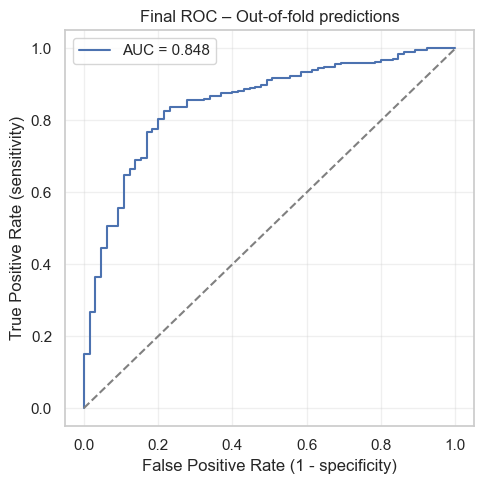

In [77]:
# ================================================================
# Cell 9: 5-fold CV – Conv1D (± engineered features)
# ================================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
)
from tensorflow.keras import callbacks

# Helper: compute class weights from training labels
def compute_class_weights_local(y):
    classes, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    return {int(c): total / (len(classes) * cnt) for c, cnt in zip(classes, counts)}

n_samples  = len(y_bg)
seq_len    = X_seq_bg.shape[1]
n_channels = X_seq_bg.shape[2]
if USE_FEAT:
    assert X_feat_bg.shape[0] == n_samples
    n_feat = X_feat_bg.shape[1]
else:
    n_feat = 0

print("Using seq_len =", seq_len, "n_channels =", n_channels, "n_feat =", n_feat)

oof_prob = np.zeros(n_samples, dtype=float)
oof_true = y_bg.copy()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_seq_bg, y_bg), start=1):
    print(f"\n===== Fold {fold} =====")
    X_tr_seq, X_te_seq = X_seq_bg[train_idx], X_seq_bg[test_idx]
    y_tr, y_te         = y_bg[train_idx], y_bg[test_idx]

    if USE_FEAT and n_feat > 0:
        X_tr_feat, X_te_feat = X_feat_bg[train_idx], X_feat_bg[test_idx]

    uniq_tr, cnt_tr = np.unique(y_tr, return_counts=True)
    uniq_te, cnt_te = np.unique(y_te, return_counts=True)
    print("  Train class counts (0=essential,1=disp):", dict(zip(uniq_tr, cnt_tr)))
    print("  Test  class counts (0=essential,1=disp):", dict(zip(uniq_te, cnt_te)))

    model_cv = build_conv1d_model(
        seq_len=seq_len,
        n_channels=n_channels,
        n_feat=n_feat,
        arch="baseline",
        use_feat=USE_FEAT,
    )

    cw = compute_class_weights_local(y_tr)

    es = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=0,
    )

    if USE_FEAT and n_feat > 0:
        history = model_cv.fit(
            [X_tr_seq, X_tr_feat],
            y_tr,
            validation_data=([X_te_seq, X_te_feat], y_te),
            epochs=100,
            batch_size=8,
            callbacks=[es],
            verbose=0,
            class_weight=cw,
        )
        y_prob_fold = model_cv.predict([X_te_seq, X_te_feat], verbose=0).ravel()
    else:
        history = model_cv.fit(
            X_tr_seq,
            y_tr,
            validation_data=(X_te_seq, y_te),
            epochs=100,
            batch_size=8,
            callbacks=[es],
            verbose=0,
            class_weight=cw,
        )
        y_prob_fold = model_cv.predict(X_te_seq, verbose=0).ravel()

    y_pred_fold = (y_prob_fold >= 0.5).astype(int)

    acc = accuracy_score(y_te, y_pred_fold)
    try:
        auc = roc_auc_score(y_te, y_prob_fold)
    except ValueError:
        auc = np.nan

    print(f"  Fold {fold} – acc: {acc:.3f}, auc: {auc:.3f}")
    fold_results.append({"fold": fold, "acc": acc, "auc": auc})

    oof_prob[test_idx] = y_prob_fold

# Per-fold CV summary
fold_results_df = pd.DataFrame(fold_results)
print("\nPer-fold CV summary:")
display(fold_results_df)
print(
    "\nMean acc:", fold_results_df["acc"].mean(),
    "Mean AUC:", fold_results_df["auc"].mean()
)

# Global OOF ROC and thresholds
fpr, tpr, thr = roc_curve(oof_true, oof_prob)
auc_oof = roc_auc_score(oof_true, oof_prob)
j_idx   = np.argmax(tpr - fpr)
thr_best = thr[j_idx]

print(f"\n=== Global OOF performance ===")
print(f"AUC (OOF) = {auc_oof:.3f}")
print(f"Best threshold (Youden J) = {thr_best:.3f}")

def print_confusion(y_true, y_prob, threshold, label):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print(f"\n=== Confusion matrix at {label} (thr={threshold:.3f}) ===")
    print(cm)
    print("\nClassification report:")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=["essential (0)", "dispensable (1)"],
        )
    )

print_confusion(oof_true, oof_prob, 0.5,     "threshold 0.5")
print_confusion(oof_true, oof_prob, thr_best, "best Youden J")

# Plot ROC from OOF predictions
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_oof:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate (1 - specificity)")
plt.ylabel("True Positive Rate (sensitivity)")
plt.title("Final ROC – Out-of-fold predictions")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [78]:
# ================================================================
# Cell 10: Train final model on all background genes and predict for all genes
# ================================================================
seq_len    = X_seq_bg.shape[1]
n_channels = X_seq_bg.shape[2]
n_feat     = X_feat_bg.shape[1] if USE_FEAT else 0

model_final = build_conv1d_model(
    seq_len=seq_len,
    n_channels=n_channels,
    n_feat=n_feat,
    arch="baseline",
    use_feat=USE_FEAT,
)

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

if USE_FEAT and n_feat > 0:
    train_inputs = [X_seq_bg, X_feat_bg]
else:
    train_inputs = X_seq_bg

history_final = model_final.fit(
    train_inputs,
    y_bg,
    validation_split=0.1,
    epochs=100,
    batch_size=8,
    callbacks=[es],
    verbose=1,
    class_weight=class_weight_dict,
)

# Background predictions
if USE_FEAT and n_feat > 0:
    p_bg = model_final.predict([X_seq_bg, X_feat_bg], verbose=0).ravel()
else:
    p_bg = model_final.predict(X_seq_bg, verbose=0).ravel()

conv_pred_bg = pd.DataFrame({
    "GeneID": bg_used["GeneID"].to_numpy(),
    "label_true": y_bg,
    "p_dispensable_conv": p_bg,
})

print("\nBackground predictions (head):")
display(conv_pred_bg.head())
print("Shape:", conv_pred_bg.shape)

# All-gene predictions (for downstream use)
if USE_FEAT and n_feat > 0:
    p_all = model_final.predict([X_seq, X_feat_all], verbose=0).ravel()
else:
    p_all = model_final.predict(X_seq, verbose=0).ravel()

conv_pred_all = pd.DataFrame({
    "GeneID": genes_conv,
    "p_dispensable_conv": p_all,
})

print("\nAll-gene predictions (head):")
display(conv_pred_all.head())
print("All-gene predictions shape:", conv_pred_all.shape)

out_pred_path = Path("../Output/conv1d_pred_all_genes_multichannel_augFeat.parquet" if USE_FEAT
                     else "../Output/conv1d_pred_all_genes_multichannel_seqOnly.parquet")
conv_pred_all.to_parquet(out_pred_path)
print("Saved all-gene predictions to:", out_pred_path)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6733 - auc: 0.6400 - loss: 1.3562 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 1.7922
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8187 - auc: 0.7186 - loss: 0.7396 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 1.4666
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7908 - auc: 0.7045 - loss: 0.8847 - val_accuracy: 0.2059 - val_auc: 0.0000e+00 - val_loss: 1.2280
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7901 - auc: 0.7275 - loss: 0.5091 - val_accuracy: 0.4706 - val_auc: 0.0000e+00 - val_loss: 1.1204
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7687 - auc: 0.6673 - loss: 0.9412 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 2.4996
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8773 - auc: 0.6943 - loss: 0.9100 - val_accuracy: 0.1471 - val_auc: 0.0000e+00 - val_loss: 1.9133
Epoc

,GeneID,label_true,p_dispensable_conv
0,PF3D7_0102200,1,0.979009
1,PF3D7_0102500,1,0.657297
2,PF3D7_0107600,1,1.000000
3,PF3D7_0112200,1,0.989862
4,PF3D7_0113000,1,0.960878


Shape: (337, 3)

All-gene predictions (head):


,GeneID,p_dispensable_conv
0,PF3D7_0100100,0.266399
1,PF3D7_0100200,0.321406
2,PF3D7_0100300,0.300456
3,PF3D7_0100400,0.354736
4,PF3D7_0100600,0.357007


All-gene predictions shape: (5312, 2)
Saved all-gene predictions to: ../Output/conv1d_pred_all_genes_multichannel_seqOnly.parquet


N background genes with predictions: 337

=== Confusion matrix at threshold 0.5 (rows=true 0,1; cols=pred 0,1) ===
[[ 52  13]
 [ 43 229]]

Metrics at 0.5:
  TN=52, FP=13, FN=43, TP=229
  Accuracy : 0.834
  Sensitivity (TPR, disp=1): 0.842
  Specificity (TNR, ess=0): 0.800

Classification report at 0.5:
                precision    recall  f1-score   support

  essential(0)       0.55      0.80      0.65        65
dispensable(1)       0.95      0.84      0.89       272

      accuracy                           0.83       337
     macro avg       0.75      0.82      0.77       337
  weighted avg       0.87      0.83      0.84       337

AUC: 0.882
Best threshold by Youden's J (TPR-FPR): 0.457

=== Confusion matrix at best threshold (rows=true 0,1; cols=pred 0,1) ===
[[ 52  13]
 [ 33 239]]

Metrics at best threshold:
  Threshold : 0.457
  Accuracy  : 0.864
  Sensitivity (TPR, disp=1): 0.879
  Specificity (TNR, ess=0): 0.800


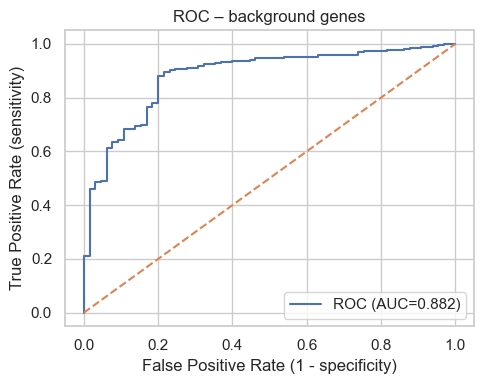

In [79]:
# ================================================================
# Cell 11: Evaluation on background set – confusion, report, ROC
# ================================================================
y_true = conv_pred_bg["label_true"].to_numpy()
y_prob = conv_pred_bg["p_dispensable_conv"].to_numpy()

# Confusion and report at threshold 0.5
thr_default = 0.5
y_pred_05 = (y_prob >= thr_default).astype(int)

cm_05 = confusion_matrix(y_true, y_pred_05, labels=[0, 1])
TN, FP, FN, TP = cm_05.ravel()

print(f"N background genes with predictions: {len(y_true)}\n")
print("=== Confusion matrix at threshold 0.5 (rows=true 0,1; cols=pred 0,1) ===")
print(cm_05)
print("\nMetrics at 0.5:")
print(f"  TN={TN}, FP={FP}, FN={FN}, TP={TP}")

acc_05 = accuracy_score(y_true, y_pred_05)
tpr_05 = TP / (TP + FN) if (TP + FN) > 0 else np.nan
tnr_05 = TN / (TN + FP) if (TN + FP) > 0 else np.nan
print(f"  Accuracy : {acc_05:.3f}")
print(f"  Sensitivity (TPR, disp=1): {tpr_05:.3f}")
print(f"  Specificity (TNR, ess=0): {tnr_05:.3f}")

print("\nClassification report at 0.5:")
print(classification_report(y_true, y_pred_05, target_names=["essential(0)", "dispensable(1)"]))

# ROC / AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc_val = roc_auc_score(y_true, y_prob)
print(f"AUC: {auc_val:.3f}")

# Best threshold by Youden's J (= TPR - FPR)
youden = tpr - fpr
best_idx = np.argmax(youden)
best_thr = thresholds[best_idx]
print(f"Best threshold by Youden's J (TPR-FPR): {best_thr:.3f}")

y_pred_best = (y_prob >= best_thr).astype(int)
cm_best = confusion_matrix(y_true, y_pred_best, labels=[0, 1])
TNb, FPb, FNb, TPb = cm_best.ravel()
acc_best = accuracy_score(y_true, y_pred_best)
tpr_best = TPb / (TPb + FNb) if (TPb + FNb) > 0 else np.nan
tnr_best = TNb / (TNb + FPb) if (TNb + FPb) > 0 else np.nan

print("\n=== Confusion matrix at best threshold (rows=true 0,1; cols=pred 0,1) ===")
print(cm_best)
print("\nMetrics at best threshold:")
print(f"  Threshold : {best_thr:.3f}")
print(f"  Accuracy  : {acc_best:.3f}")
print(f"  Sensitivity (TPR, disp=1): {tpr_best:.3f}")
print(f"  Specificity (TNR, ess=0): {tnr_best:.3f}")

# ROC plot
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc_val:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate (1 - specificity)")
plt.ylabel("True Positive Rate (sensitivity)")
plt.title("ROC – background genes")
plt.legend()
plt.tight_layout()
plt.show()

conv_sorted shape: (5312, 3)
rank_map shape: (5312, 3)
bg_plot shape (after dedupe & merge): (334, 7)
Missing ranks in bg_plot: 0
N JA wrong rows: 13
N JA wrong IDs overlapping conv_pred_all: 13
ja_wrong_plot shape (after overlap filter): (13, 26)
Missing ranks in ja_wrong_plot: 0


,GeneID,geneName,KO,label,rank,p_dispensable_conv
0,PF3D7_0530200,iTPT,Essential,0,2175,0.419634
1,PF3D7_0104400,IspH,Essential,0,3210,0.718526
2,PF3D7_1452300,Der1-1,Essential,0,2222,0.423927
3,PF3D7_1020800,aPDH E2,Disp,1,5161,1.000000
4,PF3D7_1344600,LipA,Disp,1,4659,0.999392


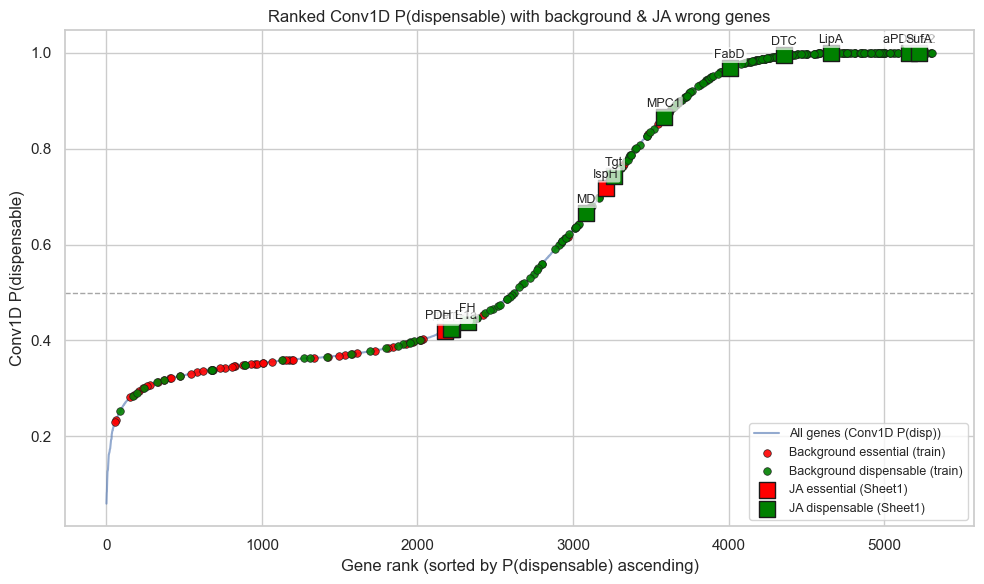

In [80]:
# ================================================================
# Cell 12: Ranked P(dispensable) with background + JA wrong genes
# ================================================================
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 1) Rank all genes by Conv1D P(dispensable)
# ------------------------------------------------------------
conv_sorted = (
    conv_pred_all
    .sort_values("p_dispensable_conv")
    .reset_index(drop=True)
    .copy()
)
conv_sorted["rank"] = np.arange(1, len(conv_sorted) + 1)

rank_map = conv_sorted[["GeneID", "rank", "p_dispensable_conv"]].copy()

print("conv_sorted shape:", conv_sorted.shape)
print("rank_map shape:", rank_map.shape)

# ------------------------------------------------------------
# 2) Background (training) genes – ensure 1 row / GeneID
# ------------------------------------------------------------
bg_plot = (
    bg_used
    .drop_duplicates(subset=["GeneID"])
    .merge(rank_map, on="GeneID", how="left")
)

print("bg_plot shape (after dedupe & merge):", bg_plot.shape)
print("Missing ranks in bg_plot:", bg_plot["rank"].isna().sum())

# ------------------------------------------------------------
# 3) JA wrong genes (from ja_wrong created in Cell 7)
#    ja_wrong already has: GeneID, geneName, KO, label (0/1)
# ------------------------------------------------------------
ja_wrong_src = ja_wrong.drop_duplicates(subset=["GeneID"]).copy()

# Overlap between JA wrong PF3D7 IDs and conv_pred_all
ja_ids   = ja_wrong_src["GeneID"].astype(str)
conv_ids = conv_pred_all["GeneID"].astype(str)
overlap  = set(ja_ids).intersection(set(conv_ids))

print(f"N JA wrong rows: {len(ja_wrong_src)}")
print(f"N JA wrong IDs overlapping conv_pred_all: {len(overlap)}")

ja_wrong_src = ja_wrong_src[ja_wrong_src["GeneID"].isin(overlap)].copy()

# Merge with rank / P(disp)
ja_wrong_plot = ja_wrong_src.merge(rank_map, on="GeneID", how="left")

print("ja_wrong_plot shape (after overlap filter):", ja_wrong_plot.shape)
print("Missing ranks in ja_wrong_plot:", ja_wrong_plot["rank"].isna().sum())
display(
    ja_wrong_plot[["GeneID", "geneName", "KO", "label", "rank",
                   "p_dispensable_conv"]].head()
)

# ------------------------------------------------------------
# 4) Plot ranked curve + overlays
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))

# Background curve: all genes
plt.plot(
    conv_sorted["rank"],
    conv_sorted["p_dispensable_conv"],
    lw=1.5,
    alpha=0.6,
    label="All genes (Conv1D P(disp))",
    zorder=1,
)

# Training genes (sheet "Lab KOs"): circles
bg_ess_mask  = (bg_plot["label"] == 0)
bg_disp_mask = (bg_plot["label"] == 1)

plt.scatter(
    bg_plot.loc[bg_ess_mask, "rank"],
    bg_plot.loc[bg_ess_mask, "p_dispensable_conv"],
    c="red",
    s=30,
    marker="o",
    edgecolor="k",
    linewidth=0.5,
    alpha=0.9,
    label="Background essential (train)",
    zorder=2,
)

plt.scatter(
    bg_plot.loc[bg_disp_mask, "rank"],
    bg_plot.loc[bg_disp_mask, "p_dispensable_conv"],
    c="green",
    s=30,
    marker="o",
    edgecolor="k",
    linewidth=0.5,
    alpha=0.9,
    label="Background dispensable (train)",
    zorder=2,
)

# JA wrong genes: squares, colored by JA KO label
ja_ess_mask  = (ja_wrong_plot["label"] == 0)
ja_disp_mask = (ja_wrong_plot["label"] == 1)
ja_unlabeled = ja_wrong_plot["label"].isna()

plt.scatter(
    ja_wrong_plot.loc[ja_ess_mask, "rank"],
    ja_wrong_plot.loc[ja_ess_mask, "p_dispensable_conv"],
    c="red",
    s=140,
    marker="s",
    edgecolor="k",
    linewidth=1.0,
    alpha=1.0,
    label="JA essential (Sheet1)",
    zorder=4,
)

plt.scatter(
    ja_wrong_plot.loc[ja_disp_mask, "rank"],
    ja_wrong_plot.loc[ja_disp_mask, "p_dispensable_conv"],
    c="green",
    s=140,
    marker="s",
    edgecolor="k",
    linewidth=1.0,
    alpha=1.0,
    label="JA dispensable (Sheet1)",
    zorder=4,
)

if ja_unlabeled.any():
    plt.scatter(
        ja_wrong_plot.loc[ja_unlabeled, "rank"],
        ja_wrong_plot.loc[ja_unlabeled, "p_dispensable_conv"],
        c="blue",
        s=140,
        marker="s",
        edgecolor="k",
        linewidth=1.0,
        alpha=1.0,
        label="JA (unlabeled)",
        zorder=4,
    )

# ------------------------------------------------------------
# 5) Annotate JA wrong genes with geneName
# ------------------------------------------------------------
if "geneName" in ja_wrong_plot.columns:
    for _, row in ja_wrong_plot.dropna(subset=["rank"]).iterrows():
        plt.text(
            row["rank"],
            row["p_dispensable_conv"] + 0.015,
            str(row["geneName"]),
            fontsize=9,
            ha="center",
            va="bottom",
            zorder=5,
            bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.7),
        )

plt.axhline(0.5, color="gray", linestyle="--", lw=1, alpha=0.7, zorder=0)

plt.xlabel("Gene rank (sorted by P(dispensable) ascending)")
plt.ylabel("Conv1D P(dispensable)")
plt.title("Ranked Conv1D P(dispensable) with background & JA wrong genes")
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()


Conv1D latent feature matrix shape (background): (337, 64)


/Users/kourosh.zarringhalam/miniconda3/envs/scvelo_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


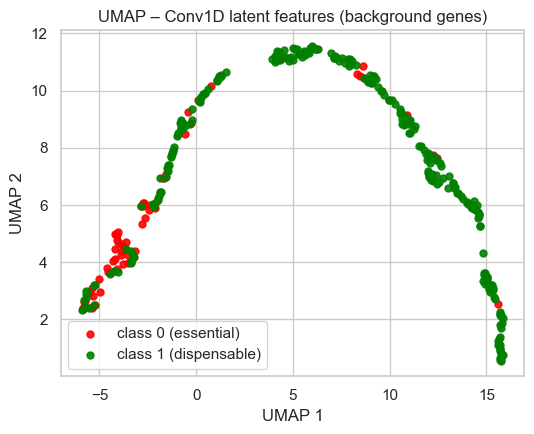

Engineered feature matrix shape (background): (337, 11)


/Users/kourosh.zarringhalam/miniconda3/envs/scvelo_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


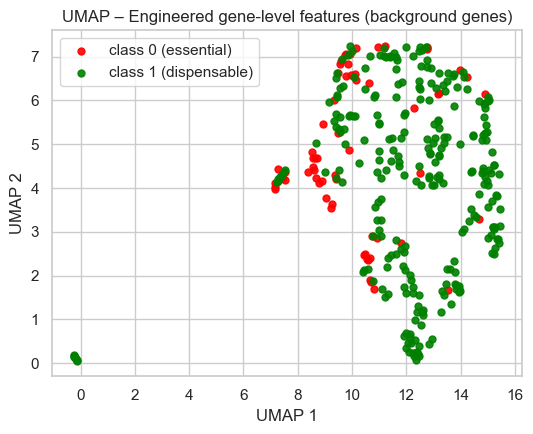

In [81]:
# ================================================================
# Cell 13: UMAPs – Conv1D latent vs engineered features (background genes)
# ================================================================
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1) Conv1D latent UMAP
# -----------------------------
latent_layer = model_final.get_layer("latent")
feature_extractor = Model(inputs=model_final.inputs, outputs=latent_layer.output)

if USE_FEAT:
    Z_conv_bg = feature_extractor.predict([X_seq_bg, X_feat_bg], verbose=0)
else:
    Z_conv_bg = feature_extractor.predict(X_seq_bg, verbose=0)

print("Conv1D latent feature matrix shape (background):", Z_conv_bg.shape)

try:
    import umap
    UMAP = umap.UMAP
except ImportError:
    import umap.umap_ as umap
    UMAP = umap.UMAP

umap_seq = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
Z_emb_seq = umap_seq.fit_transform(Z_conv_bg)

plt.figure(figsize=(5.5, 4.5))
palette = {0: "red", 1: "green"}
for cls_val in [0, 1]:
    mask = (y_bg == cls_val)
    plt.scatter(
        Z_emb_seq[mask, 0],
        Z_emb_seq[mask, 1],
        c=palette[cls_val],
        s=25,
        alpha=0.9,
        label=f"class {cls_val} ({'essential' if cls_val == 0 else 'dispensable'})",
    )

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP – Conv1D latent features (background genes)")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Engineered features UMAP
# -----------------------------
from sklearn.preprocessing import StandardScaler

# X_feat_bg: (n_bg, n_feat) from engineered features cell
print("Engineered feature matrix shape (background):", X_feat_bg.shape)

# Standardize for UMAP (optional but usually helps)
scaler = StandardScaler()
X_feat_bg_scaled = scaler.fit_transform(X_feat_bg)

umap_feat = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
Z_emb_feat = umap_feat.fit_transform(X_feat_bg_scaled)

plt.figure(figsize=(5.5, 4.5))
for cls_val in [0, 1]:
    mask = (y_bg == cls_val)
    plt.scatter(
        Z_emb_feat[mask, 0],
        Z_emb_feat[mask, 1],
        c=palette[cls_val],
        s=25,
        alpha=0.9,
        label=f"class {cls_val} ({'essential' if cls_val == 0 else 'dispensable'})",
    )

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP – Engineered gene-level features (background genes)")
plt.legend()
plt.tight_layout()
plt.show()
